# Ad hoc analysis for ICTALS

### Outline
1. Show changes in single neuron behaviour
2. Show change in avalanche size
3. Quantify avalanche size in GABRG2
4. Show network cycle differences

## Housekeeping

In [1]:
import os
import re 
import glob
import numpy as np
import matplotlib.pyplot as plt
import cde_net_ictals as cn
import networkx as nx
from scipy import stats

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

In [2]:
# Define folder locations and such
#---------------------------------------------------------------------
F        = {}
F['dom'] = '/Users/roschkoenig/Dropbox/Research/1901 Fish2p/suite2p data/Project'
F['gb2'] = F['dom'] + os.sep + 'LIGHTSTIM-GABRG2--'
F['gct'] = F['dom'] + os.sep + 'LIGHTSTIM-WILDTYPE'
F['ptz'] = F['dom'] + os.sep + 'PTZ' +os.sep+ 'filtered'

## Locate and load relevant datasets 

### PTZ dataset

In [3]:
# Load actual datasets - PTZ 
#---------------------------------------------------------------------
conditions = {'bln':'Baseline', 'p05':'PTZ 5mM', 'p20':'PTZ 20mM'}
spatial_conversion = [.5, .5, 15]
Fish = []

for key in conditions.keys():
    folds = glob.glob(F['ptz'] + os.sep + '*'+key)
    for f in folds:
        tracefile = glob.glob(f +os.sep+ '*all_sig.npy')[0]
        coordfile = glob.glob(f +os.sep+ '*all_cord.npy')[0]
        fish                = {}
        fish['Voxels']      = np.load(coordfile)
        fish['Coordinates'] = np.multiply(fish['Voxels'], spatial_conversion)
        fish['Data']        = np.load(tracefile)
        fish['Condition']   = conditions[key]
        Fish.append(fish)
        
        if fish['Coordinates'].shape[0] != fish['Data'].shape[0]: 
            raise Exception('The data and coordinates do not match in length for: \n \n' 
                            + coordfiles[k] + ' \n and \n' + tracefiles[k])
 
        if fish['Data'].shape == (0,0):
            raise Exception('Data are empty for : \n \n' 
                            + coordfile + ' \n and \n' + tracefile)
    
    
    

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


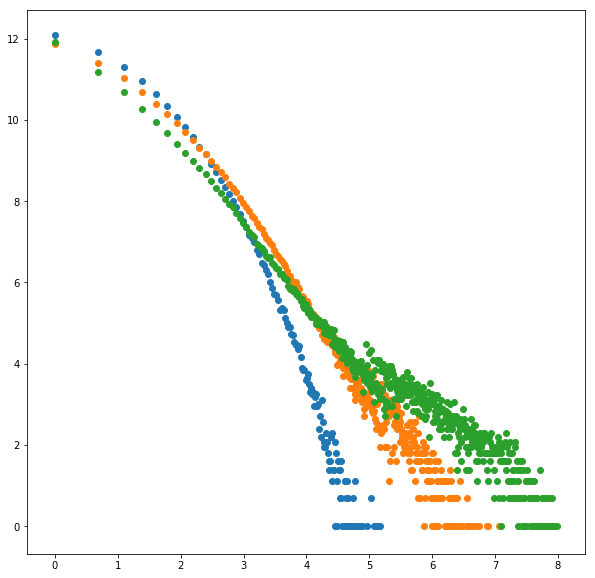

In [3]:
pconds = {'bln':'Baseline', 'p05':'PTZ at 5mM', 'p20':'PTZ at 20mM'}
lvals  = {}
durdat = np.ndarray((0,0,0))
[fig, ax] = plt.subplots(1, figsize = (10,10))
pi     = 0 

for p in pconds.keys():
    files = glob.glob(F['dom'] +os.sep+ 'PTZ' +os.sep+ 
                      'criticality' +os.sep+ 'size' +os.sep+ '*' +p+ '.npy')
    bins      = np.exp(np.linspace(0,8,1000))
    allcounts = np.ndarray([0,len(bins)-1])
    
#     for f in files:
    f = files[8]
    x = np.load(f)
    [cnts, vals] = np.histogram(x,bins)
    allcounts = np.vstack((allcounts,cnts))
    
    
    ax.scatter(np.log(bins[:-1]),np.log(np.mean(allcounts,0)))
#     ax.axis('equal')
        

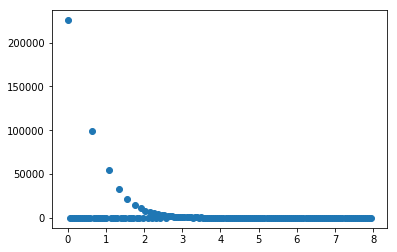

In [162]:
for ai in range(allcounts.shape[0]):
    plt.scatter(np.log(bins[:-1]),allcounts[ai,:])

## Network cycle difference 

### Reducing dimensionality of the data to regional agerages

In [4]:
for f in range(len(Fish)): Fish[f] = cn.spacek(Fish[f])

In [ ]:
arange = []
for a in range(10):
    cd = []
    for f in range(len(Fish)):
        print('Now working on fish ' + str(f+1) + ': ' + Fish[f]["Condition"]) 
        (dt,lb,cs) = cn.average(Fish[f]["Data"], Fish[f]["KLabel"], Fish[f]["Coordinates"])

        # Network construction
        #=====================================================================
        # Calculate correlation coefficient
        #---------------------------------------------------------------------
        A  = np.corrcoef(dt)
        np.fill_diagonal(A, 0)

        # Z-score and binarise according to z cut off
        #---------------------------------------------------------------------
    #     A  = stats.zscore(np.ravel(A)).reshape(A.shape)
        bA = A > (a / 10)

        # Generate Network x object from this
        #---------------------------------------------------------------------
        G = nx.from_numpy_matrix(bA)

        # Calculate cycle density
        #=====================================================================
        cycs = nx.algorithms.cycle_basis(G)
        no_E = G.number_of_edges()
        if no_E > 0: ncd = len(nx.algorithms.cycle_basis(G)) / no_E
        else:        ncd = 0

        cd.append(ncd)
        
    arange.append(cd)

In [24]:
swp = np.zeros((3,10))
ai  = 0
for a in arange:
    swp[0,ai] = np.mean(a[0:9])
    swp[1,ai] = np.mean(a[10:19])
    swp[2,ai] = np.mean(a[20:])
        
    ai = ai + 1

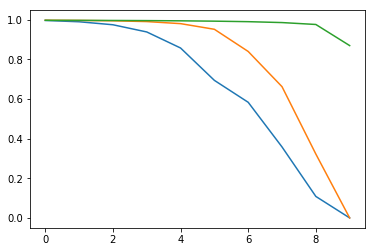

In [25]:
plt.plot(np.transpose(swp))

In [26]:
f = 0
a = 0.5 
        
(dt,lb,cs) = cn.average(Fish[f]["Data"], Fish[f]["KLabel"], Fish[f]["Coordinates"])

# Network construction
#=====================================================================
# Calculate correlation coefficient
#---------------------------------------------------------------------
A  = np.corrcoef(dt)
np.fill_diagonal(A, 0)

# Z-score and binarise according to z cut off
#---------------------------------------------------------------------
bA = A > (a / 10)

# Generate Network x object from this
#---------------------------------------------------------------------
G = nx.from_numpy_matrix(bA)


/Users/roschkoenig/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


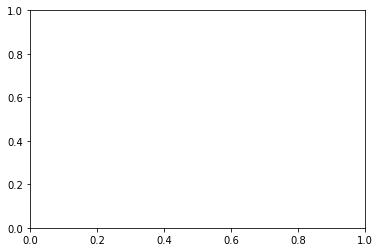

In [43]:
cs = Fish[f]['Coordinates'][:,0:2]
ps = {}
for c in range(cs.shape[0]): ps.update({c:cs[c,:]})
nx.draw_networkx_edges(G, pos = ps)

In [50]:
# Load actual datasets - GABRG2 
#---------------------------------------------------------------------
conditions = {'gb2':'GABRG2 Knockout'}
spatial_conversion = [.5, .5, 15]
Fish       = []

for key in conditions.keys():
    tracefiles = glob.glob(F[key] + os.sep + '*realtrace.npy')
    coordfiles = glob.glob(F[key] + os.sep + '*realcoord.npy')
    tracefiles.sort()
    coordfiles.sort()
    
    for k in range(len(tracefiles)):
        try: 
            print('Working on fish file ' +str(k))
            fish = {}
            fish['Voxels']      = np.load(coordfiles[k])
            fish['Coordinates'] = np.multiply(fish['Voxels'] , spatial_conversion)
            fish['Data']        = np.load(tracefiles[k])
            fish['Condition']   = conditions[key]
            Fish.append(fish)

            if fish['Coordinates'].shape[0] != fish['Data'].shape[0]: 
                raise Exception('The data and coordinates do not match in length for: \n \n' 
                                + coordfiles[k] + ' \n and \n' + tracefiles[k])
        except: 
            print('Skipping ' + tracefiles[k])

Working on fish file 0
Working on fish file 1
Working on fish file 2
Working on fish file 3


In [53]:
for f in range(len(Fish)): 
    print('Spatial k-Means for Fish ' + str(f))
    Fish[f] = cn.spacek(Fish[f])

Spatial k-Means for Fish 0
Spatial k-Means for Fish 1
Spatial k-Means for Fish 2
Spatial k-Means for Fish 3


In [54]:
arange = []
for a in range(10):
    cd = []
    for f in range(len(Fish)):
        print('Now working on fish ' + str(f+1) + ': ' + Fish[f]["Condition"]) 
        (dt,lb,cs) = cn.average(Fish[f]["Data"], Fish[f]["KLabel"], Fish[f]["Coordinates"])

        # Network construction
        #=====================================================================
        # Calculate correlation coefficient
        #---------------------------------------------------------------------
        A  = np.corrcoef(dt)
        np.fill_diagonal(A, 0)

        # Z-score and binarise according to z cut off
        #---------------------------------------------------------------------
    #     A  = stats.zscore(np.ravel(A)).reshape(A.shape)
        bA = A > (a / 10)

        # Generate Network x object from this
        #---------------------------------------------------------------------
        G = nx.from_numpy_matrix(bA)

        # Calculate cycle density
        #=====================================================================
        cycs = nx.algorithms.cycle_basis(G)
        no_E = G.number_of_edges()
        if no_E > 0: ncd = len(nx.algorithms.cycle_basis(G)) / no_E
        else:        ncd = 0

        cd.append(ncd)
        
    arange.append(cd)

Now working on fish 1: GABRG2 Knockout
Now working on fish 2: GABRG2 Knockout
Now working on fish 3: GABRG2 Knockout
Now working on fish 4: GABRG2 Knockout
Now working on fish 1: GABRG2 Knockout
Now working on fish 2: GABRG2 Knockout
Now working on fish 3: GABRG2 Knockout
Now working on fish 4: GABRG2 Knockout
Now working on fish 1: GABRG2 Knockout
Now working on fish 2: GABRG2 Knockout
Now working on fish 3: GABRG2 Knockout
Now working on fish 4: GABRG2 Knockout
Now working on fish 1: GABRG2 Knockout
Now working on fish 2: GABRG2 Knockout
Now working on fish 3: GABRG2 Knockout
Now working on fish 4: GABRG2 Knockout
Now working on fish 1: GABRG2 Knockout
Now working on fish 2: GABRG2 Knockout
Now working on fish 3: GABRG2 Knockout
Now working on fish 4: GABRG2 Knockout
Now working on fish 1: GABRG2 Knockout
Now working on fish 2: GABRG2 Knockout
Now working on fish 3: GABRG2 Knockout
Now working on fish 4: GABRG2 Knockout
Now working on fish 1: GABRG2 Knockout
Now working on fish 2: GA

In [57]:
swp = np.zeros((1,10))
ai  = 0
for a in arange:
    swp[0,ai] = np.mean(a)
    ai = ai + 1

In [5]:
plt.violinplot(cd[0:9],[1], showmeans = True)
plt.violinplot(cd[10:19],[2], showmeans = True)
plt.violinplot(cd[20:],[3], showmeans = True)

[s, p1] = stats.mannwhitneyu(cd[0:9], cd[10:19])
[s, p2] = stats.mannwhitneyu(cd[10:19], cd[20:])
[s, p3] = stats.mannwhitneyu(cd[0:9], cd[20:])
print(str(p1) +' '+str(p2)+' '+str(p3))

NameError: name 'cd' is not defined

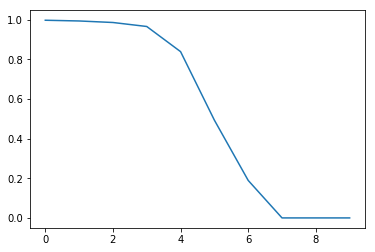

In [58]:
plt.plot(np.transpose(swp))